In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML
# import line_profiler as lp 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, functional
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import sys
sys.path.append('../src')
# from model import *
from model2D import *
from datagen import *
from analysis import *
from datagen2D import *

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU: ", device)
else:
    device = torch.device("cpu")
    print("Running on CPU")

torch.set_default_device(device)
# torch.cuda.synchronize()
torch._dynamo.config.suppress_errors = True
torch.set_float32_matmul_precision("high")

/home/mattis/anaconda3/envs/torch2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on GPU:  cuda:0
Running on GPU:  cuda:0


/home/mattis/anaconda3/envs/torch2/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mattis/anaconda3/envs/torch2/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mattis/anaconda3/envs/torch2/lib/python3.10/site-packages/umap/d

Running on GPU:  cuda:0


In [4]:
# # Generate dataset and save in ../datasets
# # First generate gradual gradual dataset

def train_gradual_gen(epochs,batch_size=64,per=15):
    i = 0
    training_steps = 1
    gen_data = []
    for epoch in tqdm(range(epochs)):
        # data,labels = smooth_wandering_2D_squarefix(batch_size,training_steps,bound=0.5,v_sigma=0.01,d_sigma=0.08,v_bound_reduction=0.15,stability=0.0)
        # data,labels = smooth_wandering_2D_squarefix_randomstart_hdv(batch_size,training_steps,bound=0.5,v_sigma=0.02,d_sigma=0.08,v_bound_reduction=0.15,stability=0.0)
        data,labels = smooth_wandering_2D_squarefix_randomstart_hdv_vrng(batch_size,training_steps,bound=0.5,v_sigma_mean=0.01,d_sigma=0.08,v_bound_reduction=0.15,stability=0.0)
        # data,labels = smooth_wandering_2D_squarefix_hdv(batch_size,training_steps,bound=0.5,v_sigma=0.01,d_sigma=0.08,v_bound_reduction=0.15,stability=0.0)
        # data,labels = smooth_wandering_2D_squarefix(test_batch_size,t_test)
        # data,labels = rat_box(batch_size,training_steps)
        gen_data.append((data.cpu().detach(),labels.cpu().detach()))
        i+=1
        if i%per == 0:
            training_steps += 1
    print("Last training time steps:",training_steps)
    return gen_data
    # Save dataset

def train_constant(epochs,batch_size=64,training_steps=200):
    gen_data = []
    for epoch in tqdm(range(epochs)):
        # data,labels = smooth_wandering_2D_squarefix(batch_size,training_steps,bound=0.5,v_sigma=0.01,d_sigma=0.1,v_bound_reduction=0.15,stability=0.01)
        # data,labels = smooth_wandering_2D_squarefix_randomstart_hdv(batch_size,training_steps,bound=0.5,v_sigma=0.01,d_sigma=0.08,v_bound_reduction=0.15,stability=0.0)
        data,labels = smooth_wandering_2D_squarefix_randomstart_hdv_vrng(batch_size,training_steps,bound=0.5,v_sigma_mean=0.01,d_sigma=0.08,v_bound_reduction=0.15,stability=0.0)
        # data,labels = smooth_wandering_2D_squarefix(test_batch_size,t_test)
        # data,labels = rat_box(batch_size,training_steps)
        gen_data.append((data.cpu().detach(),labels.cpu().detach()))
    print("Last training time steps:",training_steps)
    return gen_data

batch_size = 64
per = 10
epochs = 2000
t_steps = 200
# gen_data = train_gradual_gen(epochs,batch_size=batch_size,per=per)
gen_data = train_constant(epochs,batch_size=batch_size,training_steps=t_steps)
# np.save("../datasets/gradual_2D_hdv_randomstart_vrng2_{}_{}_{}".format(epochs,per,batch_size),gen_data) # Will be saved as [Epochs,data/labels,batchsize,tsteps,x/y]
np.save("../datasets/constant_2D_hdv_randomstart_{}_{}_{}".format(epochs,t_steps,batch_size),gen_data) # Will be saved as [Epochs,data/labels,batchsize,tsteps,x/y]


100%|██████████| 2000/2000 [01:08<00:00, 29.38it/s]


Last training time steps: 200


In [ ]:
class Datamodel(Dataset):
    def __init__(self,time_pos_points,labels):
        self.x = time_pos_points
        self.y = labels
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]
    
data = input_data[:,0]
labels = input_data[:,1]
datamodel = Datamodel(data, labels)
data_loader = DataLoader(datamodel, batch_size=1, shuffle=False, num_workers=1)

In [51]:
batch_size = 64
training_steps = 200

# data,labels = smooth_wandering_2D_squarefix_randomstart_hdv(batch_size,training_steps,bound=0.5,v_sigma=0.02,d_sigma=0.08,v_bound_reduction=0.15,stability=0.0)
data,labels = smooth_wandering_2D_squarefix_randomstart_hdv_vrng(batch_size,training_steps,bound=0.5,v_sigma_mean=0.01,d_sigma=0.08,v_bound_reduction=0.15,stability=0.0)

In [4]:
data, labels = rat_box(64,200)

100%|██████████| 64/64 [00:14<00:00,  4.45it/s]


In [53]:
data[:,1:,1,:].mean()

tensor(0.0138, device='cuda:0')

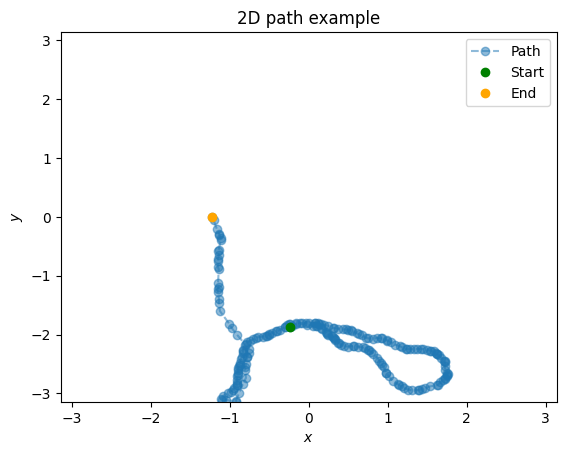

In [61]:
path = labels.cpu().detach().numpy()
path.shape

n = 31
plt.plot(path[n,:,0], path[n,:,1], '--o',alpha=0.5)
# # Plot first
plt.plot(path[n,0,0],path[n,0,1],"o",color="green")
# # Plot last
plt.plot(path[n,-1,0],path[n,-1,1],"o",color="orange")
plt.title("2D path example")
plt.xlim(-np.pi,np.pi)
plt.ylim(-np.pi,np.pi)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend(["Path","Start","End"])
plt.show()